# ACSE 7 Data Assimilation assessment

_Expected completion time:_
- Part I: less than 30 minutes
- Part II: less than 2 hours 30 minutes

The forced one-dimensional viscous Burgers' equation occurs frequently in fluid dynamics and acoustics. In form it is very similar to the Navier-Stokes equations you saw in ACSE-3,

$$ \frac{\partial u}{\partial t} +u\frac{\partial u}{\partial z} = \nu \frac{\partial^2 u}{\partial z^2} +r(z).$$

Here $u$ is the variable of interest, $z$ is the independent variable representing space in the domain and $r(z)$ is a given forcing term. For numerical convenience it is also common to write the advective term $u\frac{\partial u}{\partial z}$ in a conservative form,
$$ \frac{\partial u}{\partial t} +\frac{1}{2}\frac{\partial u^2}{\partial z} = \nu \frac{\partial^2 u}{\partial z^2} +r(z).$$

You have been provided with observational data of $u$ for a number of time levels at $z=5$ and $z=-5$ from a Burger's model system in a periodic domain of period 20. In the region $[-10, 10]$ $r(z)$ takes the form $100\sin\left(\frac{3t}{8}\right)\exp(-100z^2)$.

## Part I

Consider the following potential data assimilation strategies:

- Multiple 4D-Var assimilation events
- Multiple OI assimilation events
- A single OI assimilation
- A single 4D-Var assimilation
- Multiple iterations of the ordinary Kalman filter
- Multiple 3D-Var assimialtion events

Place the six possible strategies in order from most appropriate to least appropriate in order to generate an accurate forcast at the time $t=100$. For each strategy include a _short_ (i.e one paragraph or less) explanation of why you have placed it where you have.

#### Insert answer here

Most appropriate

  1. Multiple 4D-Var assimilation events. As with the 3D-Var method iwhen compared with OI, 4D-Var turns the Kalman Filter into a logically consistant problem which includes the nonlinearities present in the real world, and which can be attacked by existing optimization techniques.
  Meanwhile, the multiple method can make the analysis more stable compared to single method
  2. A single 4D-Var assimilation. Compared to Kalman filter, 4D-Var turns the Kalman Filter into a logically consistant problem which includes the nonlinearities present in the real world, and which can be attacked by existing optimization techniques
  3. Multiple iterations of the ordinary Kalman filter. This has considered time in modelling comparing with 3D-Var assimilation and OI assimilation.
  4. Multiple 3D-Var assimilation events. 3D-Var can define a (potentially) nonlinear *observation operator* as a function mapping the state variable values into the observation space
  5. Multiple OI assimilation events. multiple method can make the analysis more stable compared to single method
  6. A single OI assimilation. It can only represent linear relationship between the observation data and state vector
  
Least appropriate

## Part II

You may assume that the observations are independent, with Gaussian errors with standard deviation 0.05 (at $z=-5$ ) and 0.1 (at $z=5$). The supplied observational data and background error covariance matrix can be loaded using the following code block:

In [19]:
# observations data is in array form y[timelevel, location]
# where location 0 is z=-5 and location 1 is z=5
#
# The actual time value is stored in the t_obs array

import numpy as np
data = np.load('burgers_observations.npz')
t_obs = data['t_obs']
y = data['y']
print(y.shape)
# B is the (sparse) background error covariance matrix

def generate_B_matrix(z):
    B = np.empty([len(z), len(z)])
    
    for _ in range(len(z)):
        B[_, :] = 0.2**2*np.exp(-4*(z[_]-z)**2)*((z[_]-z)**2<=4)
    return B

(80, 2)


- Implement your best data assimilation strategy to provide a forecast at $t=100$ for an initial background at $t=0$ of $u=1$ (i.e $x_b$=1) using the observations, background error covariance matrix and observation statistices provided. 
- Write a short (i.e three paragraph or less) description of your method, and of any potential issues that it will not be able to cope with.

For your convenience, you may use the following forecast model, or write your own.


In [20]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import inv

z = np.linspace(-10, 10, 61)
dz = z[1]-z[0]
u = np.full(z.shape, 1.0)
nu = 0.4
dt = 0.05

B = generate_B_matrix(z)

## Use forward Euler for the (nonlinear) advection  and Crank-Nicolson for diffusion
def rhs(U, dt, t):
    out = np.empty(U.shape)
    out[0] = U[0]-0.5*dt/dz*(U[1]**2-U[-1]**2-nu*(U[-1]-2*U[0]+U[1])/dz)
    out[1:-1] = U[1:-1]-0.5*dt/dz*(U[2:]**2-U[:-2]**2-nu*(U[:-2]-2*U[1:-1]+U[2:])/dz)
    out[-1] = U[-1]-0.5*dt/dz*(U[0]**2-U[-2]**2-nu*(U[-2]-2*U[-1]+U[0])/dz)
    
    return out+dt*10*np.sin(.375*np.pi*(t+0.5*dt))*np.exp(-100*z**2)

def lhs_matrix(u, dt):
    mat = np.eye(u.shape[0])
    mat[0,-1] -= 0.5*dt*nu/dz**2
    mat[0, 0] += dt*nu/dz**2
    mat[0, 1] -= 0.5*dt*nu/dz**2
    for _ in range(1, u.shape[0]-1):
        mat[_, _-1] -= 0.5*dt*nu/dz**2
        mat[_, _] += dt*nu/dz**2
        mat[_, _+1] -= 0.5*dt*nu/dz**2
    mat[-1,-2] -= 0.5*dt*nu/dz**2
    mat[-1, -1] += dt*nu/dz**2
    mat[-1, 0] -= 0.5*dt*nu/dz**2
    return mat

def burgers_equation(u0, dt, t_final):
    t = 0.0
    u = u0
    out = [u0]
    mat = lhs_matrix(u0, dt)
    matinv = inv(mat)
    while t<t_final:
        for _ in range(10):
            u = matinv.dot(rhs(u, dt, t))
            t += dt
        out.append(u)
    return out

In [21]:
## Add new code cells as needed

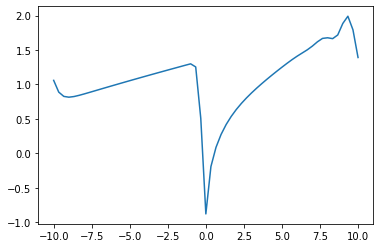

In [22]:
x = burgers_equation(u, dt, 100)
plt.plot(z, x[-1]);

In [23]:
# number of places we need to record
num_u = 61
u0 = u


nt = 100 / (10 * dt) + 1 + 1
nt = int(nt)

# compute the inverse of matrix B
Binv = inv(B)

# construct matrix R
R = np.zeros((y.shape[1],y.shape[1]))
R[0,0] = 0.05 ** 2
R[1,1] = 0.1 ** 2

# construct operator h
h = np.zeros((y.shape[1], z.size))

for i in range(5):
    h[0,13+i] = 0.2  # centered on z = -5
    h[1,43+i] = 0.2  # centered on z = 5
# h[0,15] = 0.00000001  # z = -5
# h[1,45] = 0.00000001 # z = 5

# compute u_t, here denoted by x
x = burgers_equation(u0, dt, 100)
x = np.array(x)
u_b = np.ones(x.shape[1])

### Adjoint model
PDE MODEL:
$$ \frac{\partial u}{\partial t} +\frac{1}{2}\frac{\partial u^2}{\partial z} = \nu \frac{\partial^2 u}{\partial z^2} +r(z).$$

First, substitute $u \rightarrow  u+\delta u$ and collect all the terms involving one copy of $\delta u$ to build our tangent linear model

$$  \frac{\partial (u+\delta u)}{\partial t} +\frac{1}{2}\frac{\partial (u+\delta u)^2}{\partial z} = \nu \frac{\partial^2 (u+\delta u)}{\partial z^2} +r(z)
$$

$$  \frac{\partial u}{\partial t}+\frac{\partial \delta u}{\partial t}+\frac{1}{2}(\frac{\partial u^2}{\partial z}+\frac{\partial 2(u\delta u)}{\partial z}+\frac{\partial (\delta u)^2}{\partial z}) = \nu \frac{\partial^2 u}{\partial z^2}+\nu \frac{\partial^2 (\delta u)}{\partial z^2} +r(z)
$$

i.e.

$$
\frac{\partial (u\delta u)}{\partial z} = u\frac{\partial \delta u}{\partial z} + \delta u\frac{\partial u}{\partial z}
$$ 

This truns up in the continuous cost function in an integral, so can integrate by parts

$$ \int\lambda(\frac{\partial \delta u}{\partial t}+ \frac{\partial (u\delta u)}{\partial z}- \nu \frac{\partial^2 \delta u}{\partial z^2})d\Omega dt
$$

$$ \int\delta u(\frac{\partial \lambda}{\partial t}+ \frac{\partial (u\lambda)}{\partial z}- \nu \frac{\partial^2 \lambda}{\partial z^2})d\Omega dt
$$

This gives us our continuous adjoint equation

$$
\frac{\partial \lambda}{\partial t}= -\frac{\partial (u\lambda)}{\partial z}+ \nu \frac{\partial^2 \lambda}{\partial z^2}
$$

we are going to integrate this backwards in time

$$
\lambda_{k} = \lambda_{k+1} - \Delta t( -\frac{\partial (u_{k+1}\lambda_{k+1})}{\partial z}+ \nu \frac{\partial^2 \lambda_{k+1}}{\partial z^2})
$$

Now for space(the nasties part)

$$
u_{k+1}^{i} = u_{k}^{i} + \Delta t \left[ -\frac{1}{2}\frac{(u_{k}^{i+1})^2-(u_{k}^{i-1})^2}{2\Delta z} + \nu \frac{u_{k}^{i+1} -2u_{k}^{i} +u_{k}^{i-1}}{\Delta z^2} \right]
$$

Play the linearization trick for each of the individual $u_{k}^{i}$

$$
\delta u_{k+1}^{i} = \delta u_{k}^{i} + \Delta t \left[ -u_{k}^{i} \frac{\delta u_{k}^{i+1}-\delta u_{k}^{i-1}}{2\Delta z} - \delta u_{k}^{i}\frac{ u_{k}^{i+1}- u_{k}^{i-1}}{2\Delta z} +\nu \frac{\delta u_{k}^{i+1} -2 \delta u_{k}^{i} +\delta u_{k}^{i-1}}{\Delta z^2}  \right]
$$

Now having picked our numbering, we can actually write down the form of our matrix

$$
M = \left[
\begin{matrix}
 1-\frac{u_{k}^1 \Delta t}{2\Delta z}-\frac{2\nu\Delta t}{\Delta z^2}    & -\frac{u_{k}^{0} \Delta t} {2\Delta z}+\frac{\nu\Delta t}{\Delta z^2}   & 0  & \cdots   & \cdots & 0      \\
 \frac{\Delta t u_{k}^1}{2\Delta z}+\frac{\Delta t \nu}{\Delta z^2}      & 1-\frac{(u_{k}^2 - u_{k}^0) \Delta t}{2\Delta z}-\frac{2\nu\Delta t}{\Delta z^2}  & -\frac{u_{k}^{1} \Delta t} {2\Delta z}+\frac{\nu\Delta t}{\Delta z^2}  & 0   & \ddots & 0      \\
 0 &\frac{\Delta t u_{k}^2}{2\Delta z}+\frac{\Delta t \nu}{\Delta z^2}      & 1-\frac{(u_{k}^3 - u_{k}^1) \Delta t}{2\Delta z}-\frac{2\nu\Delta t}{\Delta z^2}  & -\frac{u_{k}^{2} \Delta t} {2\Delta z}+\frac{\nu\Delta t}{\Delta z^2}    & \ddots & 0      \\
 \vdots & \ddots & \ddots & \ddots  & \ddots  & \vdots \\
  \vdots & \ddots &  \frac{\Delta t u_{k}^{n-3}}{2\Delta z}+\frac{\Delta t \nu}{\Delta z^2}      & 1-\frac{(u_{k}^{n-2} - u_{k}^{n-4}) \Delta t}{2\Delta z}-\frac{2\nu\Delta t}{\Delta z^2}  & -\frac{u_{k}^{n-3} \Delta t} {2\Delta z}+\frac{\nu\Delta t}{\Delta z^2} & 0\\
 \vdots & \ddots & 0 & \frac{\Delta t u_{k}^{n-2}}{2\Delta z}+\frac{\Delta t \nu}{\Delta z^2}      & 1-\frac{(u_{k}^{n-1} - u_{k}^{n-3}) \Delta t}{2\Delta z}-\frac{2\nu\Delta t}{\Delta z^2}  & -\frac{u_{k}^{n-2} \Delta t} {2\Delta z}+\frac{\nu\Delta t}{\Delta z^2} \\
  0  & \cdots & \cdots & 0 &\frac{\Delta t u_{k}^{n-1}}{2\Delta z}+\frac{\Delta t \nu}{\Delta z^2} & 1+\frac{u_{k}^{n-2} \Delta t}{2\Delta z}-\frac{2\nu\Delta t}{\Delta z^2} 
\end{matrix}
\right]
$$

In [24]:
# compute last lamda
lamdaN = h.T @ np.linalg.inv(R) @ (y[-1,:] - h @ x[-1])

# construct M
M = np.zeros((z.size,z.size))
M = np.eye(z.size)
for i in range(z.size-1):
    M[i,i+1] = dt * nu / dz**2
    M[i+1,i] = dt * nu / dz**2

for i in range(z.size):
    M[i,i] = - 2 * dt * nu / dz**2

In [25]:
# modified adjoint_model function
def adjoint_model(x, y, h):
    """
    x : result of burgers equation
    """
    lamda = h.T @ np.linalg.inv(R) @ (y[-1,:] - h @ x[-1])
    nt = y.shape[0]
    for t in range(1, int(nt)):
        tmp = M.copy()
        for i in range(z.size-1):
            tmp[i,i+1] -= dt*x[-t-1,i] / 2 / dz
            tmp[i+1,i] += dt*x[-t-1,i + 1] / 2 / dz
        for i in range(1,z.size-1):
            tmp[i,i] = (x[-t-1,i+1] - x[-t-1,i-1]) * dt / 2 / dz
        tmp[0,0] += x[-t-1,1] * dt / 2 / dz
        tmp[-1,-1] += x[-t-1,-2] * dt / 2 / dz
        
        lamda = tmp.T @ lamda - h.T @ np.linalg.inv(R) @ (y[-t-1,:] - h @ x[-t-1])
        
    return lamda

In [26]:
### Define the 4DVar cost function

# modified cost function
def j(x0, y, h):
    x = burgers_equation(u0, dt, 100)
    x = np.array(x)
    j_b0 = 0.5*(x0-x_b).dot(Binv.dot((x0-x_b)))
    j_b = j_b0
    for _ in range(80):
        j_b += 0.5*np.sum((y[_,:] - h @ x[_]).T@np.linalg.inv(R) @ (y[_,:] - h @ x[_]))
    return j_b

### And the function giving the gradient with respect to x_0

# modified derivative of cost function
def jac(x0, y, h):
    x = burgers_equation(u0, dt, 100)
    x = np.array(x)
    jac= Binv.dot(x0-x_b) + adjoint_model(x, y, h)
    return jac

Cost function for $x_b$ 4048.51607227356
Cost function for $x_a$ 4048.51607227356


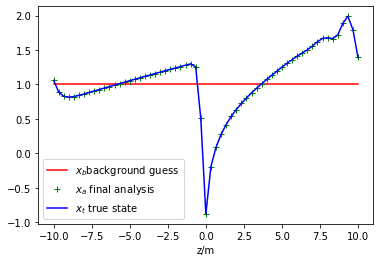

In [27]:
%matplotlib inline
from matplotlib import pyplot as p

# 4D var implementation for a diffusion problem with swarth observational data
from scipy.optimize.linesearch import line_search_armijo as line_search

### iterate with a basic linesearch to minimise the cost function and generate the 
### analysis state.

x_a = x_b.copy()
j0 = j(x_a, y, h)
for _ in range(100):
    pk = -jac(x_a, y, h)
    res = line_search(j, x_a, pk, -pk, j0, args=(y, h), alpha0=1)
    x_a += res[0]*pk
    j0 = res[2]
    if res[0]<0.000001:
        break

### Now plot some figures

print('Cost function for $x_b$', j(x_b, y, h))
print('Cost function for $x_a$', j(x_a, y, h))

# compute the analysis output updated by our model
x_f = burgers_equation(x_a,dt,100)

fig = p.figure()
ax = fig.add_subplot(111)
ax.plot(z,x_b,'-r',label='$x_{b}$background guess')
ax.plot(z,x_f[-1],'+g',label='$x_{a}$ final analysis')
ax.plot(z,x[-1],'b',label='$x_{t}$ true state')
ax.set_xlabel('z/m')
ax.legend()